In [ ]:
# preprocessing of stroke from 500 hz to 160 hz 
import os
from pathlib import Path
import numpy as np
import pandas as pd
import mne

#  Load Shared Events File (500 Hz-based sample indices)
events_path = Path(r"D:\ai\eeg_data\stroke\task-motor-imagery_events.tsv")
events_df = pd.read_csv(events_path, sep="\t")

#  Stroke Subjects List
stroke_subjects = [f"sub-{i:02}" for i in range(1, 51)]

for subj in stroke_subjects:
    print(f"▶️ Processing STROKE: {subj}")
    try:
        # Paths
        edf_path = Path(f"D:/ai/eeg_data/stroke/edffile/{subj}/eeg/{subj}_task-motor-imagery_eeg.edf")
        output_dir = Path(f"preprocessed_trials/stroke/{subj}")
        output_dir.mkdir(parents=True, exist_ok=True)

        #  Load raw EEG
        raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)

        #  Clean channel names: remove dots and make uppercase
        cleaned_ch_names = {ch: ch.replace('.', '').upper() for ch in raw.ch_names}
        raw.rename_channels(cleaned_ch_names)

        orig_sfreq = raw.info['sfreq']  # = 500.0

        #  Resample to 160 Hz
        new_sfreq = 160
        raw.resample(new_sfreq)
        scale = new_sfreq / orig_sfreq

        #  Preprocessing
        raw.info['bads'] = []
        raw.interpolate_bads()
        raw.filter(0.5, 40., fir_design='firwin')
        raw.set_eeg_reference('average')

        # ICA
        ica = mne.preprocessing.ICA(n_components=20, random_state=97, max_iter="auto")
        ica.fit(raw)
        raw = ica.apply(raw)

        #  Select stim2.mp4 events
        ev_all = events_df[events_df["stim_file"] == "stim2.mp4"].copy()

        #  Adjust event onsets/durations for new sfreq
        ev_all["onset"] = (ev_all["onset"] * scale).astype(int)
        ev_all["duration"] = (ev_all["duration"] * scale).astype(int)

        #  Convert to seconds
        ev_all["start_sec"] = ev_all["onset"] / new_sfreq
        ev_all["duration_sec"] = 4.0  # fixed 4 sec crop
        ev_all["end_sec"] = ev_all["start_sec"] + ev_all["duration_sec"]

        #  Only include events fully inside recording
        max_time = raw.times[-1]
        ev_all = ev_all[ev_all["end_sec"] <= max_time].reset_index(drop=True)

        #  Limit to 20 trials
        ev_all = ev_all.iloc[:20].copy()
        ev_all["label"] = 0
        ev_all["trial_id"] = [f"trial_{i+1:02}" for i in range(len(ev_all))]

        #  Save each trial
        for _, row in ev_all.iterrows():
            trial = raw.copy().crop(tmin=row["start_sec"], tmax=row["start_sec"] + 4.0)
            data = trial.get_data().T  # shape: (640, N)

            df = pd.DataFrame(data, columns=raw.ch_names)

            # 🚫 Remove last column if unnamed
            if df.columns[-1] == "":
                df = df.iloc[:, :-1]

            df.insert(0, "duration_sec", 4.0)
            df.insert(0, "onset_sec", row["start_sec"])
            df.insert(0, "label", row["label"])
            df.insert(0, "trial_id", row["trial_id"])

            df.to_csv(output_dir / f"{row['trial_id']}.csv", index=False)

        print(f" {subj}: {len(ev_all)} trials saved → {output_dir}")

    except Exception as e:
        print(f" {subj} failed: {e}")


In [ ]:
# prepocessing of normal 
import mne
import numpy as np
import pandas as pd
from pathlib import Path

# Parameters
runs_to_use = [4, 8, 12]  # Imagined left/right hand movement
label = 1
sfreq = 160
trial_duration_sec = 4.0

# Root path to data
data_root = Path("D:/ai/eeg_data/nromal/eeg-motor-movementimagery-dataset-1.0.0")

# Loop over subjects
for subj_num in range(1, 110):  # S001 to S109
    subject = f"S{subj_num:03}"
    trial_counter = 1
    output_dir = Path(f"preprocessed_trials/normal/{subject}")
    output_dir.mkdir(parents=True, exist_ok=True)

    print(f"\n==========================\n📁 Subject: {subject}")

    for run in runs_to_use:
        print(f" Processing {subject} - Run {run}")
        try:
            # Load EDF
            edf_path = data_root / subject / f"{subject}R{run:02}.edf"
            if not edf_path.exists():
                print(f" File not found: {edf_path}")
                continue

            raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)

            # Clean channel names
            cleaned_ch_names = {ch: ch.replace('.', '').upper() for ch in raw.ch_names}
            raw.rename_channels(cleaned_ch_names)

            # Preprocessing
            raw.filter(0.5, 40., fir_design='firwin')
            raw.set_eeg_reference('average')
            raw.interpolate_bads()

            # Loop over annotations
            for annot in raw.annotations:
                if annot['description'] in ['T1', 'T2']:
                    onset_sec = annot['onset']
                    end_sec = onset_sec + trial_duration_sec
                    if end_sec >= raw.times[-1]:
                        continue  # skip incomplete trial

                    # Crop and extract trial
                    trial = raw.copy().crop(tmin=onset_sec, tmax=end_sec)
                    data = trial.get_data().T  # (samples, channels)

                    # Save as DataFrame
                    df = pd.DataFrame(data, columns=trial.ch_names)
                    df.insert(0, "duration_sec", trial_duration_sec)
                    df.insert(0, "onset_sec", onset_sec)
                    df.insert(0, "label", label)
                    df.insert(0, "trial_id", f"trial_{trial_counter:02}")

                    # Save trial CSV
                    trial_path = output_dir / f"trial_{trial_counter:02}.csv"
                    df.to_csv(trial_path, index=False)
                    trial_counter += 1

            print(f"✅ Done! Total trials so far: {trial_counter - 1}")

        except Exception as e:
            print(f" Failed on {subject} Run {run}: {e}")


Extracting EDF parameters from D:\ai\eeg_data\stroke\edffile\sub-01\eeg\sub-01_task-motor-imagery_eeg.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


C:\Users\Selltricks\AppData\Local\Temp\ipykernel_13352\210768225.py:16: RuntimeWarning: Physical range is not defined in following channels:
CPz
  raw_before = mne.io.read_raw_edf(edf_path, preload=True)


Reading 0 ... 159999  =      0.000 ...   319.998 secs...
Original sampling rate: 500.0
Original channels: ['FP1', 'FP2', 'Fz', 'F3', 'F4', 'F7', 'F8', 'FCz', 'FC3', 'FC4', 'FT7', 'FT8', 'Cz', 'C3', 'C4', 'T3', 'T4', 'CPz', 'CP3', 'CP4', 'TP7', 'TP8', 'Pz', 'P3', 'P4', 'T5', 'T6', 'Oz', 'O1', 'O2', 'HEOL', 'HEOR', '']
Using matplotlib as 2D backend.


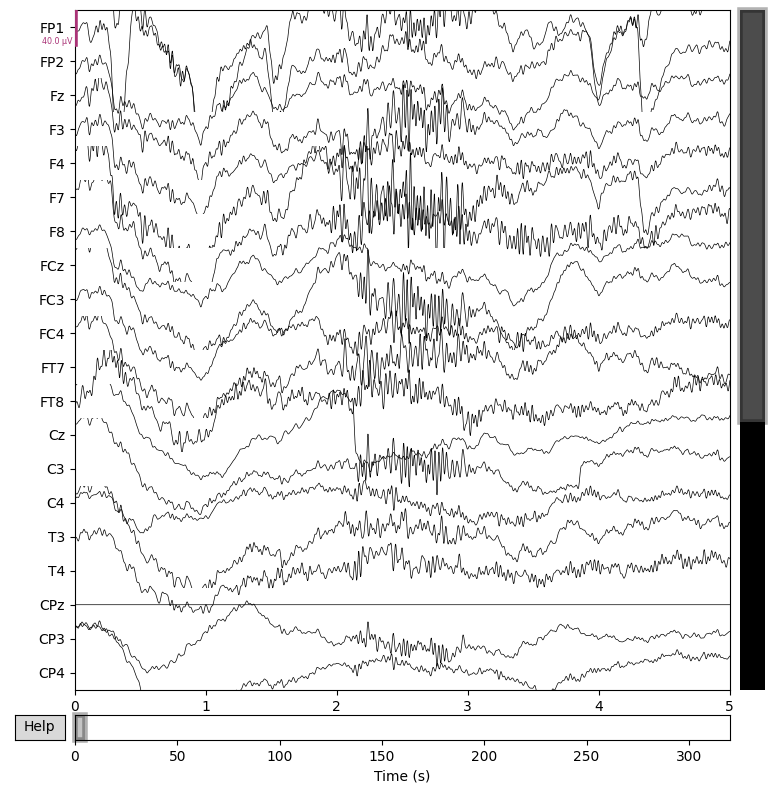

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1057 samples (6.606 sec)



C:\Users\Selltricks\AppData\Local\Temp\ipykernel_13352\210768225.py:35: RuntimeWarning: No bad channels to interpolate. Doing nothing...
  raw_after.interpolate_bads()
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.4s


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Fitting ICA to data using 33 channels (please be patient, this may take a while)
Selecting by number: 20 components
Fitting ICA took 39.9s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 33 PCA components
After preprocessing sampling rate: 160.0
Channels after preprocessing: ['FP1', 'FP2', 'FZ', 'F3', 'F4', 'F7', 'F8', 'FCZ', 'FC3', 'FC4', 'FT7', 'FT8', 'CZ', 'C3', 'C4', 'T3', 'T4', 'CPZ', 'CP3', 'CP4', 'TP7', 'TP8', 'PZ', 'P3', 'P4', 'T5', 'T6', 'OZ', 'O1', 'O2', 'HEOL', 'HEOR', '']


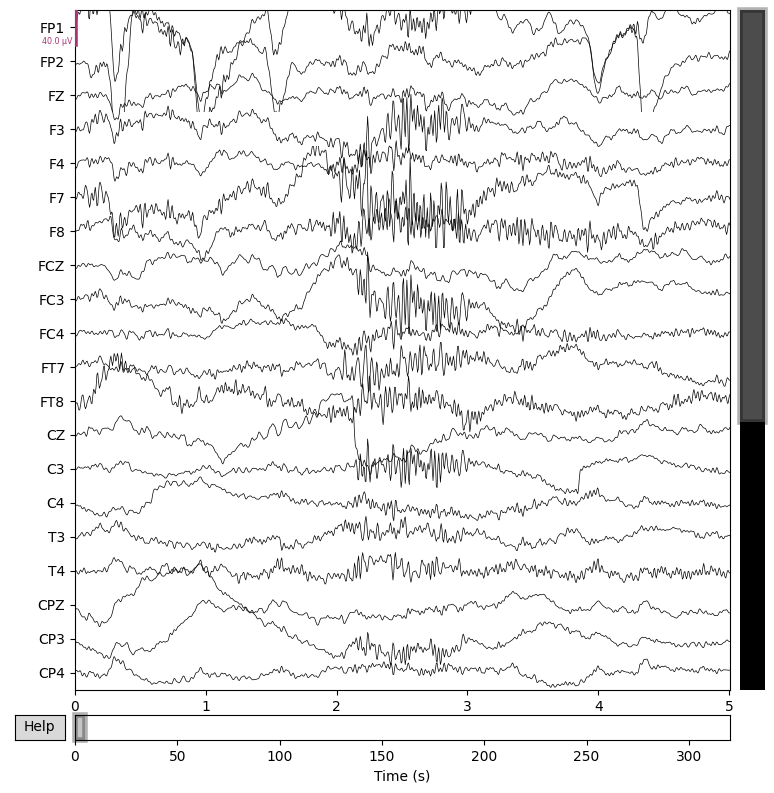

NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 4.096 (s)


C:\Users\Selltricks\AppData\Local\Temp\ipykernel_13352\210768225.py:51: UserWarning: Zero value in spectrum for channel CPZ
  fig = raw_before.plot_psd(fmax=60, show=False)
C:\Users\Selltricks\AppData\Local\Temp\ipykernel_13352\210768225.py:51: UserWarning: Infinite value in PSD for channel CPZ.
These channels might be dead.
  fig = raw_before.plot_psd(fmax=60, show=False)
C:\Users\Selltricks\AppData\Local\Temp\ipykernel_13352\210768225.py:51: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  fig = raw_before.plot_psd(fmax=60, show=False)


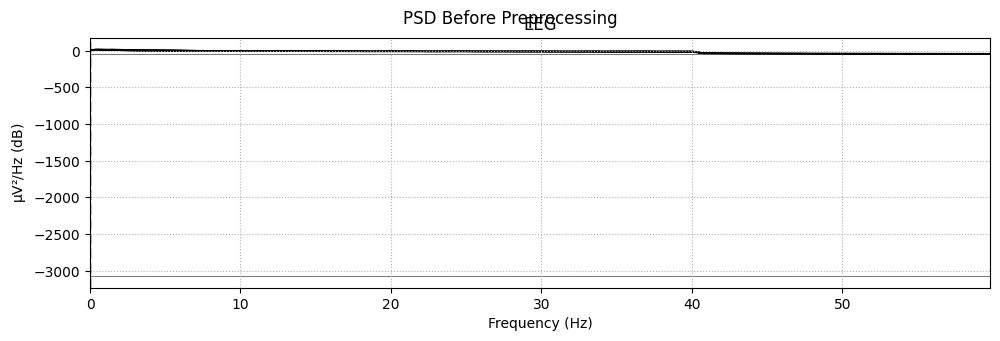

NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 12.800 (s)


C:\Users\Selltricks\AppData\Local\Temp\ipykernel_13352\210768225.py:55: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  fig = raw_after.plot_psd(fmax=60, show=False)


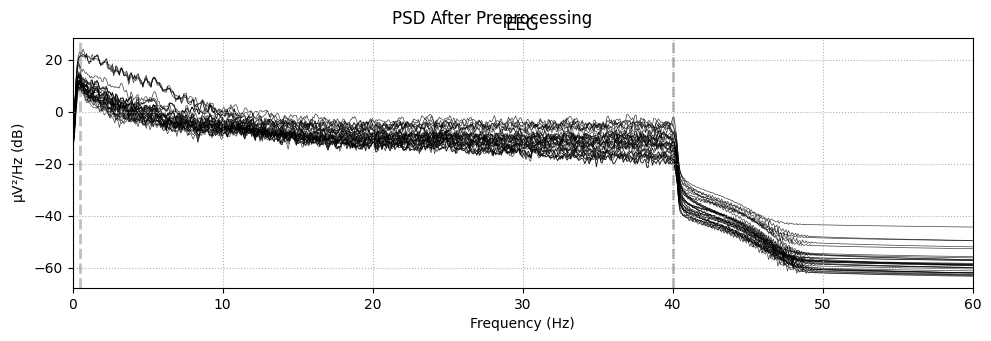

In [1]:
import mne
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path

# Pick one subject (e.g. sub-01)
subj = "sub-01"

edf_path = Path(f"D:/ai/eeg_data/stroke/edffile/{subj}/eeg/{subj}_task-motor-imagery_eeg.edf")
events_path = Path(r"D:\ai\eeg_data\stroke\task-motor-imagery_events.tsv")
events_df = pd.read_csv(events_path, sep="\t")

# -------------------
# 1) Load raw (before preprocessing)
# -------------------
raw_before = mne.io.read_raw_edf(edf_path, preload=True)

print("Original sampling rate:", raw_before.info['sfreq'])
print("Original channels:", raw_before.ch_names)

# Plot 5 seconds of raw data
raw_before.plot(duration=5, n_channels=20, title="Before Preprocessing")

# -------------------
# 2) Preprocess (same as in code 2 but only for one subject)
# -------------------
cleaned_ch_names = {ch: ch.replace('.', '').upper() for ch in raw_before.ch_names}
raw_before.rename_channels(cleaned_ch_names)

orig_sfreq = raw_before.info['sfreq']
new_sfreq = 160
raw_after = raw_before.copy().resample(new_sfreq)

raw_after.info['bads'] = []
raw_after.interpolate_bads()
raw_after.filter(0.5, 40., fir_design='firwin')
raw_after.set_eeg_reference('average')

ica = mne.preprocessing.ICA(n_components=20, random_state=97, max_iter="auto")
ica.fit(raw_after)
raw_after = ica.apply(raw_after)

print("After preprocessing sampling rate:", raw_after.info['sfreq'])
print("Channels after preprocessing:", raw_after.ch_names)

# -------------------
# 3) Plot after preprocessing
# -------------------
raw_after.plot(duration=5, n_channels=20, title="After Preprocessing")

fig = raw_before.plot_psd(fmax=60, show=False)
plt.suptitle("PSD Before Preprocessing")
plt.show()

fig = raw_after.plot_psd(fmax=60, show=False)
plt.suptitle("PSD After Preprocessing")
plt.show()




In [ ]:
# Top 10 rows of FP1 
import pandas as pd

csv_path = r"D:\ai\eeg_data\stroke\preprocessed_trials\stroke\sub-01\trial_01.csv"

df = pd.read_csv(csv_path)

# List channel columns
print("CSV Columns:", list(df.columns))

# Example: first 5 values from channel Fp1
if "FP1" in df.columns:   # after renaming your channels are uppercase
    print("Fp1 first values:", df["FP1"].head(10).to_list())
